In [1]:
import selfies as sf
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from typing import NamedTuple
from dataclasses import dataclass, asdict
import json
import requests
import time
from bs4 import BeautifulSoup

## Get Smiles

In [2]:
data_url = 'https://github.com/aspuru-guzik-group/selfies/raw/16a489afa70882428bc194b2b24a2d33573f1651/examples/vae_example/datasets/dataJ_250k_rndm_zinc_drugs_clean.txt'

pd_data = pd.read_csv(data_url)
print('Total data size', len(pd_data))

Total data size 249455


In [3]:
pd_data.head()
all_smiles = pd_data.values[:,0]

## Write function to make data


In [4]:
def fetch_page():
    """
    This fetches a random page from wikipedia and returns it as a string
    """
    url = 'https://en.wikipedia.org/wiki/Special:Random'
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    text = soup.get_text()
    return text

def mix(a, b, p=0.5):
    """    
    This function randomly replaces elements of list a with list b with probability p
    It returns the new list and the index of where replacements were made
    """
    new_a = a.copy()
    idx = np.random.choice(len(a), int(p*len(a)), replace=False)
    new_a[idx] = b[idx]
    return new_a, idx

def make_examples(p, minN=1000):
    text = fetch_page().split()
    while len(text) < 1000:
        time.sleep(1)
        text += fetch_page().split()
    wiki_text = np.array(text)
    x, idx = mix(wiki_text, all_smiles, p)
    y = np.zeros(len(x))
    y[idx] = 1
    return x,y

In [7]:
@dataclass
class Config:
    example_count: int
    vocab_size: int
    split: float
    batch_size: int
    buffer_size: int
    embedding_dim: int
    hidden_dim: int
    rnn_units: int
        
config = Config(example_count=25000,
                vocab_size=1024, 
                split=0.1,
                batch_size=64,
                buffer_size=10000, 
                embedding_dim=256, 
                hidden_dim=128,
                rnn_units=128)

## Build data

In [11]:
raw_data = make_examples(0.5, config.example_count)
tokenizer = tf.keras.preprocessing.text.Tokenizer(config.vocab_size, filters='', char_level=True)
tokenizer.fit_on_texts(raw_data[0])

In [12]:
# now get padded sequences
seqs = tokenizer.texts_to_sequences(raw_data[0])
padded_seqs = tf.keras.preprocessing.sequence.pad_sequences(seqs, padding='post')

# Now build dataset
data = tf.data.Dataset.from_tensor_slices((padded_seqs, raw_data[1]))
# now split into val, test, train and batch
N = len(raw_data[0])
split = int(config.split * N)
test_data = data.take(split).batch(config.batch_size)
nontest = data.skip(split)
val_data, train_data = nontest.take(split).batch(config.batch_size), \
    nontest.skip(split).shuffle(config.buffer_size).batch(config.batch_size)

## Build Model

In [13]:
x = tf.keras.Input(shape=(None,))
ex = tf.keras.layers.Embedding(input_dim=config.vocab_size, output_dim=config.embedding_dim, mask_zero=True)(x)
# reset_after - TFJS requires this as false
h = tf.keras.layers.GRU(config.rnn_units, reset_after=False)(ex)
h = tf.keras.layers.Dense(config.hidden_dim, activation='relu')(h)
yhat = tf.keras.layers.Dense(1)(h)
model = tf.keras.Model(inputs=x, outputs=yhat)

## Try Model

In [14]:
yhat = model(padded_seqs[:1])
yhat

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.00132936]], dtype=float32)>

In [15]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 256)         262144    
_________________________________________________________________
gru (GRU)                    (None, 128)               147840    
_________________________________________________________________
dense (Dense)                (None, 128)               16512     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 426,625
Trainable params: 426,625
Non-trainable params: 0
_________________________________________________________________


## Train

In [16]:
loss = tf.losses.BinaryCrossentropy(from_logits=True)
model.compile(tf.optimizers.Adam(1e-2), loss=loss)
result = model.fit(train_data, epochs=5)

Epoch 1/5
17/17 [==============================] - 2s 67ms/step - loss: 0.2832
Epoch 2/5
17/17 [==============================] - 1s 60ms/step - loss: 0.0038
Epoch 3/5
17/17 [==============================] - 1s 61ms/step - loss: 0.0052
Epoch 4/5
17/17 [==============================] - 1s 60ms/step - loss: 4.0691e-04
Epoch 5/5
17/17 [==============================] - 1s 60ms/step - loss: 6.2554e-05


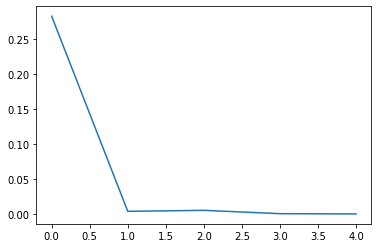

In [17]:
plt.plot(result.history['loss'])
plt.show()

## Try Inference Model

In [18]:
model.predict(tokenizer.texts_to_sequences(['Hello ']))

array([[-13.536689]], dtype=float32)

In [19]:
model.predict(tokenizer.texts_to_sequences(['C=NO ']))

array([[11.278072]], dtype=float32)

## Save Model

In [20]:
import tensorflowjs as tfjs
tfjs.converters.save_keras_model(model, '../static/model')

## Save Config

In [21]:
import json

model_info = asdict(config)
model_info['stoi'] = tokenizer.word_index
model_info['vocab'] = list(tokenizer.word_counts.keys())


with open('../src/lib/model_info.json', 'w') as f:
    json.dump(model_info, f)